In [9]:
import pandas as pd
import numpy as np
import matplotlib.yplot as plt
import os

In [18]:
plt.rcParams["figure.figsize"] = (18, 12) # (w, h)
plt.gcf().autofmt_xdate(rotation=90)
def filename(notboookname, filename):
  notebook_path = os.path.abspath(f"{notboookname}.ipynb")
  return os.path.join(os.path.dirname(notebook_path), '..', 'data', filename)

symbol    = 'btc-usd-4h'
csv_file  = filename('trendline_automation', f"{symbol}.csv")
data      = pd.read_csv(csv_file,
                        parse_dates=[0],
                        index_col=[0],
                        date_parser=lambda x: pd.to_datetime(x, utc=True))

<Figure size 1800x1200 with 0 Axes>

In [15]:
def check_trend_line(support: bool, pivot: int, slope: float, y: np.array):
    # compute sum of differences between line and prices, 
    # return negative val if invalid 
    
    # Find the intercept of the line going through pivot point with given slope
    intercept = -slope * pivot + y[pivot]
    line_vals = slope * np.arange(len(y)) + intercept
     
    diffs = line_vals - y
    
    # Check to see if the line is valid, return -1 if it is not valid.
    if support and diffs.max() > 1e-5:
        return -1.0
    elif not support and diffs.min() < -1e-5:
        return -1.0

    # Squared sum of diffs between data and line 
    err = (diffs ** 2.0).sum()
    return err;


def optimize_slope(support: bool, pivot:int , init_slope: float, y: np.array):
    
    # Amount to change slope by. Multiplyed by opt_step
    slope_unit = (y.max() - y.min()) / len(y) 
    
    # Optmization variables
    opt_step = 1.0
    min_step = 0.0001
    curr_step = opt_step # current step
    
    # Initiate at the slope of the line of best fit
    best_slope = init_slope
    best_err = check_trend_line(support, pivot, init_slope, y)
    assert(best_err >= 0.0) # Shouldn't ever fail with initial slope

    get_derivative = True
    derivative = None
    while curr_step > min_step:

        if get_derivative:
            # Numerical differentiation, increase slope by very small amount
            # to see if error increases/decreases. 
            # Gives us the direction to change slope.
            slope_change = best_slope + slope_unit * min_step
            test_err = check_trend_line(support, pivot, slope_change, y)
            derivative = test_err - best_err;
            
            # If increasing by a small amount fails, 
            # try decreasing by a small amount
            if test_err < 0.0:
                slope_change = best_slope - slope_unit * min_step
                test_err = check_trend_line(support, pivot, slope_change, y)
                derivative = best_err - test_err

            if test_err < 0.0: # Derivative failed, give up
                raise Exception("Derivative failed. Check your data. ")

            get_derivative = False

        if derivative > 0.0: # Increasing slope increased error
            test_slope = best_slope - slope_unit * curr_step
        else: # Increasing slope decreased error
            test_slope = best_slope + slope_unit * curr_step
        

        test_err = check_trend_line(support, pivot, test_slope, y)
        if test_err < 0 or test_err >= best_err: 
            # slope failed/didn't reduce error
            curr_step *= 0.5 # Reduce step size
        else: # test slope reduced error
            best_err = test_err 
            best_slope = test_slope
            get_derivative = True # Recompute derivative
    
    # Optimize done, return best slope and intercept
    return (best_slope, -best_slope * pivot + y[pivot])


def fit_trendlines_single(data: np.array):
    # find line of best fit (least squared) 
    # coefs[0] = slope,  coefs[1] = intercept 
    x = np.arange(len(data))
    coefs = np.polyfit(x, data, 1)

    # Get points of line.
    line_points = coefs[0] * x + coefs[1]

    # Find upper and lower pivot points
    upper_pivot = (data - line_points).argmax() 
    lower_pivot = (data - line_points).argmin() 
   
    # Optimize the slope for both trend lines
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], data)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], data)

    return (support_coefs, resist_coefs) 



def fit_trendlines_high_low(high: np.array, low: np.array, close: np.array):
    x = np.arange(len(close))
    coefs = np.polyfit(x, close, 1)
    # coefs[0] = slope,  coefs[1] = intercept
    line_points = coefs[0] * x + coefs[1]
    upper_pivot = (high - line_points).argmax() 
    lower_pivot = (low - line_points).argmin() 
    
    support_coefs = optimize_slope(True, lower_pivot, coefs[0], low)
    resist_coefs = optimize_slope(False, upper_pivot, coefs[0], high)

    return (support_coefs, resist_coefs)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


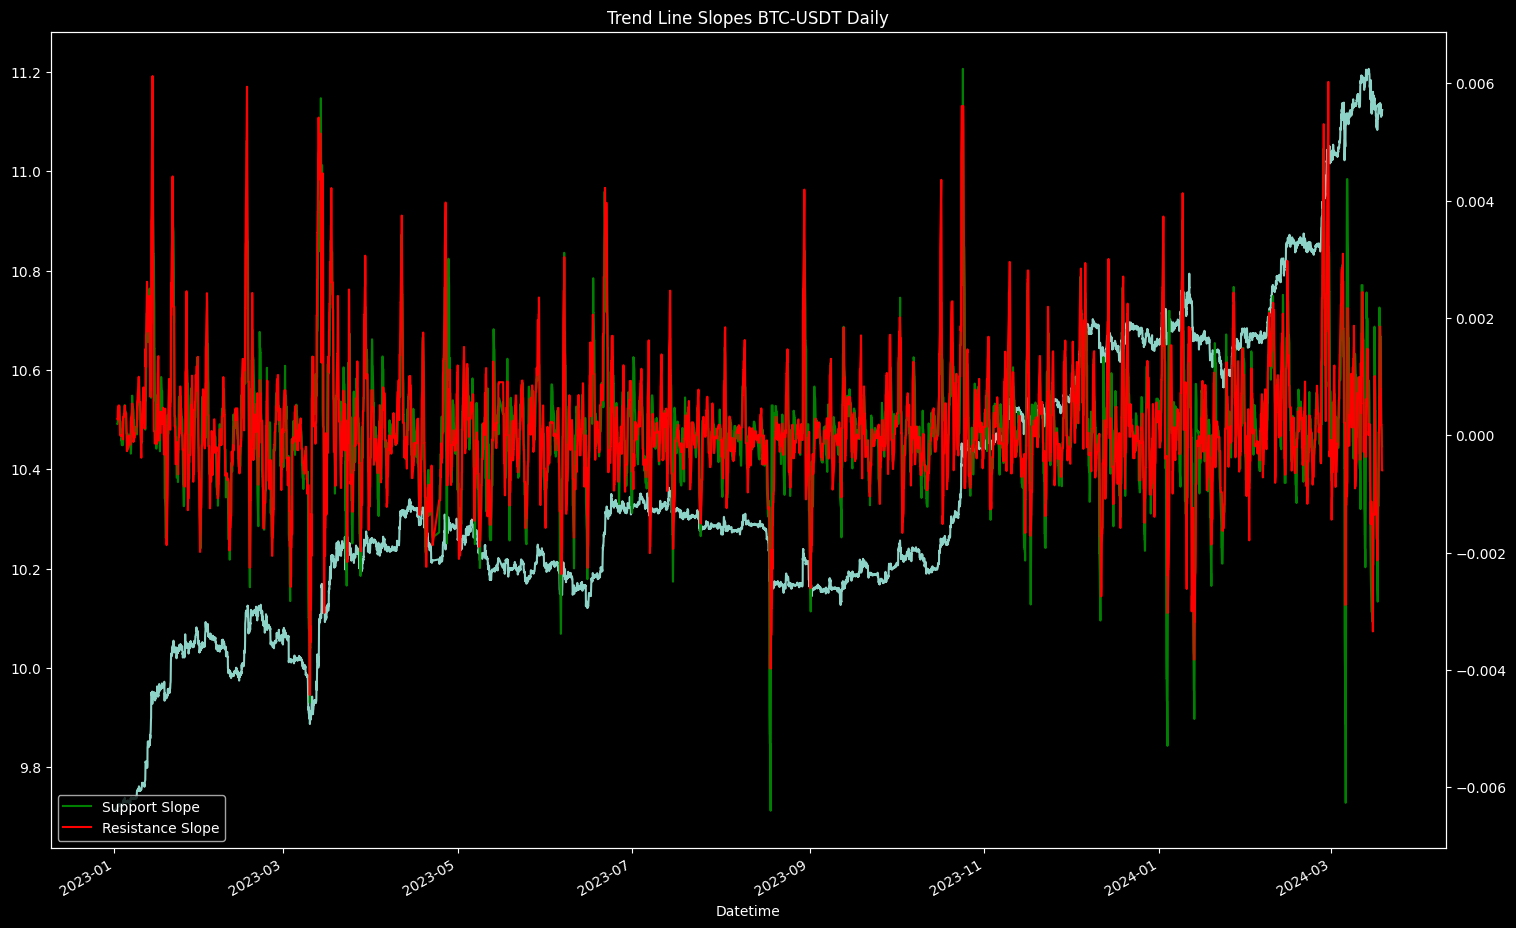

In [19]:
  # Take natural log of data to resolve price scaling issues
data = np.log(data)
# Trendline parameter
lookback = 30


support_slope = [np.nan] * len(data)
resist_slope = [np.nan] * len(data)
for i in range(lookback - 1, len(data)):
    candles = data.iloc[i - lookback + 1: i + 1]
    support_coefs, resist_coefs =  fit_trendlines_high_low(candles['High'], 
                                                            candles['Low'], 
                                                            candles['Close'])
    support_slope[i] = support_coefs[0]
    resist_slope[i] = resist_coefs[0]

data['support_slope'] = support_slope
data['resist_slope'] = resist_slope

plt.style.use('dark_background')
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
data['Close'].plot(ax=ax1)
data['support_slope'].plot(ax=ax2, label='Support Slope', color='green')
data['resist_slope'].plot(ax=ax2, label='Resistance Slope', color='red')
plt.title("Trend Line Slopes BTC-USDT Daily")
plt.legend()
plt.show()